# FlagShip
##### Author: Samuel Moran 

### Preliminary Work

In [43]:
# Import necessary libraries
import pandas as pd
import requests
import json
import influxdb_client
from influxdb import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
%matplotlib inline

In [2]:
#AUTOMATION AREA
# 1) Get company tickers to format URL string
# 2) Format string as such: "https://financialmodelingprep.com/api/v3/income-statement/" + companyName + "?datatype=csv&apikey=" + API_KEY

In [3]:
# Retrieve local API key from file (---this file is not to be pushed to GitHub for security reasons ---)
keyFile="/home/wintergreen/Projects/fskeyfile.txt"
with open(keyFile) as f:
    key = str(f.readline().replace("\n",""))
API_KEY = key

In [30]:
# Ticker indicates what company to pull data from (i.e. AAPL, AMZN, CMG, etc.)
TICKER_TARGET = "AAPL"

In [31]:
URL = "https://financialmodelingprep.com/api/v3/income-statement/" + TICKER_TARGET + "?limit=120&apikey=" + API_KEY

In [32]:
# Make request for data
r = requests.get(URL)
r = r.json()
pd.DataFrame.from_dict(r).head(5)

,date,symbol,reportedCurrency,fillingDate,acceptedDate,period,revenue,costOfRevenue,grossProfit,grossProfitRatio,...,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link,finalLink
0,2020-09-26,AAPL,USD,2020-10-30,2020-10-29 18:06:25,FY,274515000000,169559000000,104956000000,0.382332,...,0.244398,9.680000e+09,57411000000,0.209136,3.3600,3.3600,17057622000,17057622000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
1,2019-09-28,AAPL,USD,2019-10-31 00:00:00,2019-10-30 18:12:36,FY,260174000000,161782000000,98392000000,0.378178,...,0.252666,1.048100e+10,55256000000,0.212381,2.9925,2.9725,18471336000,18595652000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
2,2018-09-29,AAPL,USD,2018-11-05 00:00:00,2018-11-05 08:01:40,FY,265595000000,163756000000,101839000000,0.383437,...,0.274489,1.337200e+10,59531000000,0.224142,3.0025,2.9775,19821508000,20000436000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
3,2017-09-30,AAPL,USD,2017-11-03 00:00:00,2017-11-03 08:01:37,FY,229234000000,141048000000,88186000000,0.384699,...,0.279579,1.573800e+10,48351000000,0.210924,2.3175,2.3025,20868968000,21006768000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...
4,2016-09-24,AAPL,USD,2016-10-26 00:00:00,2016-10-26 16:42:16,FY,215639000000,131376000000,84263000000,0.390760,...,0.284605,1.568500e+10,45687000000,0.211868,2.0875,2.0775,21883280000,22001124000,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...


### Calculations

In [33]:
# Prepare the data: sort values from least recent to most recent
data = (((pd.DataFrame.from_dict(r).head(5)).sort_values(by=['fillingDate'])).reset_index()).tail()

# Combine SellingAndMarketing and generalAndAdministrative into one SGA Cost
data['SellingGeneralAdministrative'] = data.apply(lambda row: row.generalAndAdministrativeExpenses + (row.sellingAndMarketingExpenses), axis=1)

# Provide SGA costs as a percentage of Gross Profits
data['SGA_%_GP'] = data.apply(lambda row: (row.SellingGeneralAdministrative / row.grossProfit)*100, axis=1)

# Provide R&D costs as a percentage of Gross Profits
data['RD_%_GP'] = data.apply(lambda row: (row.researchAndDevelopmentExpenses / row.grossProfit)*100, axis=1)

# Provide GrossProfitMargin in a 'percentage' form
data['grossProfitMargin'] = data.apply(lambda row: row.grossProfitRatio * 100,axis=1)

# Provide Net Earnings as a percentage of Revenue
data['NE_%_RV'] = data.apply(lambda row: (row.netIncome / row.revenue) * 100,axis=1)


# Gather metrics needed for linear time-series graphs

# Compare Revenue, Gross Profits, and Net Earnings as time-series for trends in growth or decline
revGrossNet=data[['fillingDate','revenue','grossProfit','netIncome']]

# Display Gross Profit Margin over time for trends in growth or decline
grossProfitMargin = data[['fillingDate','grossProfitMargin']]

# Deplay how much (as a percentage) SGA and R&D take up Gross Profits for trends in growth or decline
SGA_RD_GP = data[['fillingDate','SGA_%_GP','RD_%_GP']]

# Display Revenue over time for trends in growth or decline
rev = data[['fillingDate','revenue']]

# Display how much a company finally retains (as %) after costs in Net Earnings from Revenue for trends in growth or decline
NE_RV = data[['fillingDate','NE_%_RV']]

# Display Earnings Per Share over time for trends in growth or decline
perShareEarnings = data[['fillingDate','eps']]

### Display Graphs

In [92]:
## THIS FUNCTION MIGHT NOT BE USEFUL IN TIME... KEEP AROUND JUST IN CASE

# # Plot the Revenue
# def graph(x, yname):
    
#     yData = []
#     print('looking up ', yname)
#     for i in data[str(yname)]:
#         yData.append(i)

#     plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#     plt.plot(x,revs)
#     plt.xlabel('Date (Years)')
#     plt.ylabel('$ USD (Billions)')
#     plt.title(str(yname))

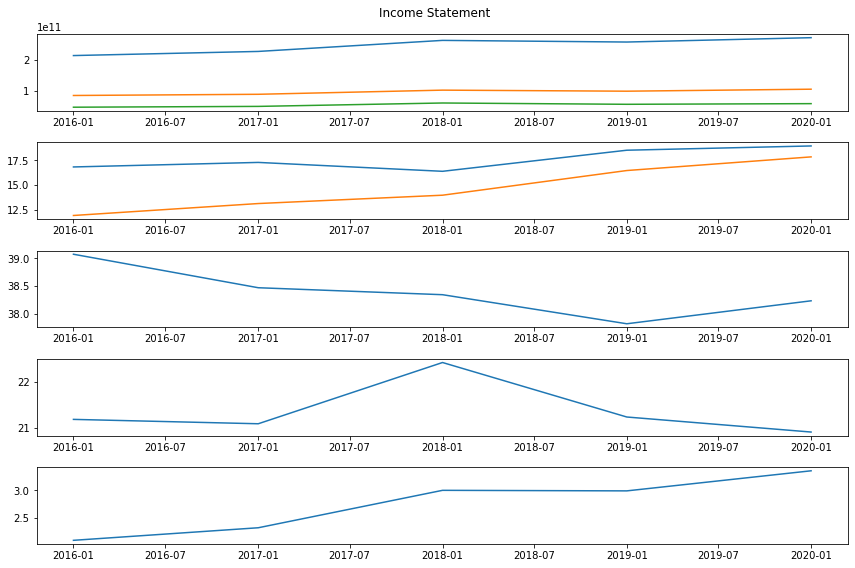

In [140]:
# Plot the data

# Display the Revenue, Gross Profits, and Net Earnings
# rgnPlot = revGrossNet.plot()
# rgnPlot.set_ylabel('Hundreds of Billions-USD')
# rgnPlot.set_xlabel('Time-5yrs')

# Get the past five dates (in years) for the x-axis
dates = []
for i in data['fillingDate']:
    date = i.split("-")[0]
    dates.append(date)

x = [dt.datetime.strptime(d,'%Y').date() for d in dates]

# Get the plots you want to provide in graphical form
plots = { "RevenueGrossAndNetIncome":["revenue","grossProfit","netIncome"],
          "SGA_R&D_AsPercentGrossProfits": ["SGA_%_GP","RD_%_GP"],
         "GrossProfitMargin_OverTime": ["grossProfitMargin"],
         "NetEarnings_%_Revenue":["NE_%_RV"],
         "EarningsPerShare":["eps"]
        }

# Plot these in graphical form as subplots
fig, axs = plt.subplots(len(plots),figsize=(12,8))
fig.suptitle("Income Statement")
fig.tight_layout()
counter = 0
for plot in plots:
    for line in plots[plot]:
        
        axs[counter].plot(x,data[str(line)])
    
    counter+=1

AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)


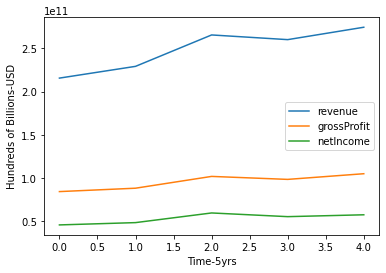

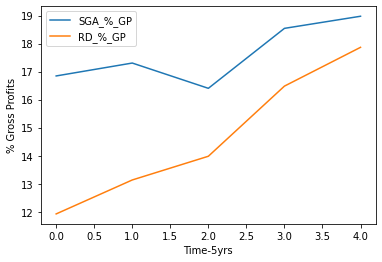

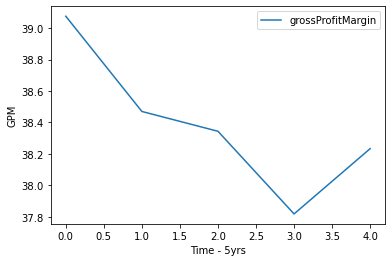

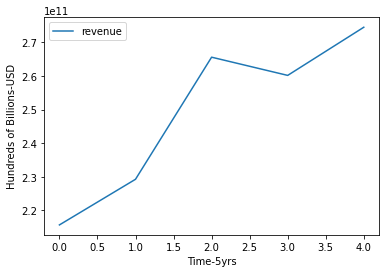

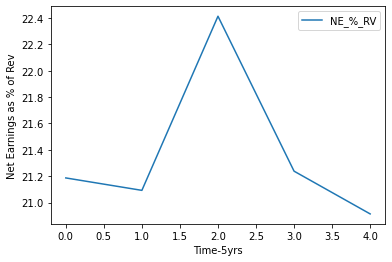

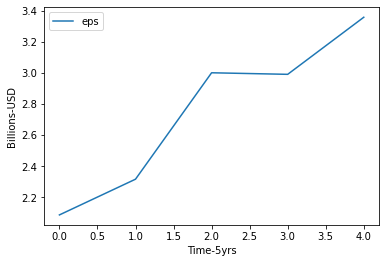

In [81]:

### OLD CODE
# Display the Revenue, Gross Profits, and Net Earnings
rgnPlot = revGrossNet.plot()
rgnPlot.set_ylabel('Hundreds of Billions-USD')
rgnPlot.set_xlabel('Time-5yrs')

#Display the SGA and R&D as percentage of Gross Profits
sgardPlot = SGA_RD_GP.plot()
sgardPlot.set_ylabel('% Gross Profits')
sgardPlot.set_xlabel('Time-5yrs')

# Display Gross Profit Margin over time
gpmPlot = grossProfitMargin.plot()
gpmPlot.set_ylabel('GPM')
gpmPlot.set_xlabel('Time - 5yrs')

# Display Revenue over time
revPlot = rev.plot()
revPlot.set_ylabel('Hundreds of Billions-USD')
revPlot.set_xlabel('Time-5yrs')

# Display company's final retention after costs over time
nervPlot = NE_RV.plot()
nervPlot.set_ylabel('Net Earnings as % of Rev')
nervPlot.set_xlabel('Time-5yrs')

# Display price per share earnings over time
eps = perShareEarnings.plot()
eps.set_ylabel('Billions-USD')
eps.set_xlabel('Time-5yrs')

print(rgnPlot, sgardPlot, gpmPlot,revPlot,nervPlot,eps)